In [1]:
import PM_1D_dirichlet as D1
import PM_2D_dirichlet as D2
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from PIL import Image

In [24]:
# Diffusion functions
g = lambda s: 1/(1+s)
g_exp = lambda s: np.exp(-s)
ϕ = lambda s: s**(1/2) * g(s)
ϕ_exp = lambda s: s**(1/2) * g_exp(s)

# Test function
def f(x, alpha):
    first = 5-np.tanh(alpha*(x-1))-np.tanh(alpha*(x-2))
    second = np.tanh(alpha*(x-4)) + np.tanh(alpha*(x-5)) + 0.1*(np.sin(5*x))**2*np.sin(50*x)
    return first+second

# Create random 1D function
def generate_random1D(M):
    I = np.zeros(M+2)
    s = (M + 2)//5
    for i in range(5):
        I[i*s:(i+1)*s+1] = 10*np.random.randint(1, 5)
    I[-1] = I[-2]
    # Add noise to interior points
    I[1:-1] = I[1:-1] + np.random.normal(0, 2, size = M)
    return I

def load_image( infilename , size = None) :
    img = Image.open( infilename )
    img.load()
    if size:
        img = img.resize(size)
    data = np.asarray( img, dtype="float32" )
    return data

# Display image given vector representation, and dimensions
def image_display(V, m, n):
    if len(V.shape) == 2:
        image = V.reshape((n, m, 3))
        return Image.fromarray(image.astype("uint8"), "RGB")

    else:
        image = V.reshape((n, m))
        return Image.fromarray(image.astype("uint8"))

def generate_squares2D(N, M):
    I = np.zeros((N+2, M+2))
    I[:N//2+1, :M//2+1] = 80
    I[:N//2+1, -(M//2+1):] = 190
    I[-(N//2+1):, :M//2+1] = 140
    I[-(N//2+1):, -(M//2+1):] = 230
    return I

def add_noise2D(I, scale = 10):
    if len(I.shape) == 3:
        N, M = I[:,:,0].shape
    else:
        N, M = I.shape
    N -= 2
    M -= 2
    if len(I.shape) == 3:
        I[1:-1, 1:-1] += np.random.randint(-scale, scale, size = (M,N, 3))
    else:
        I[1:-1, 1:-1] += np.random.randint(-scale, scale, size = (M,N))
    return I
    
def generate_random2D(M, N, scale = 10):
    I = generate_squares2D(N, M)
    add_noise2D(I)
    return I

def before_after_1D(U):
    plt.figure(figsize = (12, 12))
    plt.subplot(211)
    plt.plot(U[0])
    plt.subplot(212)
    plt.plot(U[-1])
    plt.show()

#  Perona-Malik

## Non-linear parabolic diffusion equation

**Huso, Huglen, Myklebust, Riseth**

$$
u_t = \nabla \cdot (g(\left|\nabla u\right|) \nabla u))
$$

* Used in image processing, and image restoration.
* A technique for reducing noise, and smoothing functions without removing important details, e.g. edges and lines.
* Often referred to as *anisotropic diffusion*. 
    * Not quite right, but easily modified:

$$
u_t = \nabla \cdot \left(
\begin{bmatrix}
g(\left|u_x\right|) & 0 \\
0 & g(\left|u_y\right|)
\end{bmatrix}
\nabla u
\right)
$$


In [3]:
M = 600
T = 2300
dt  = 1e-8

x = np.linspace(0, 6, M+2)
s = np.linspace(0, 10, 100)
I = f(x, 100)
U = D1.solve_BE(I, g_exp, M, T, dt) 

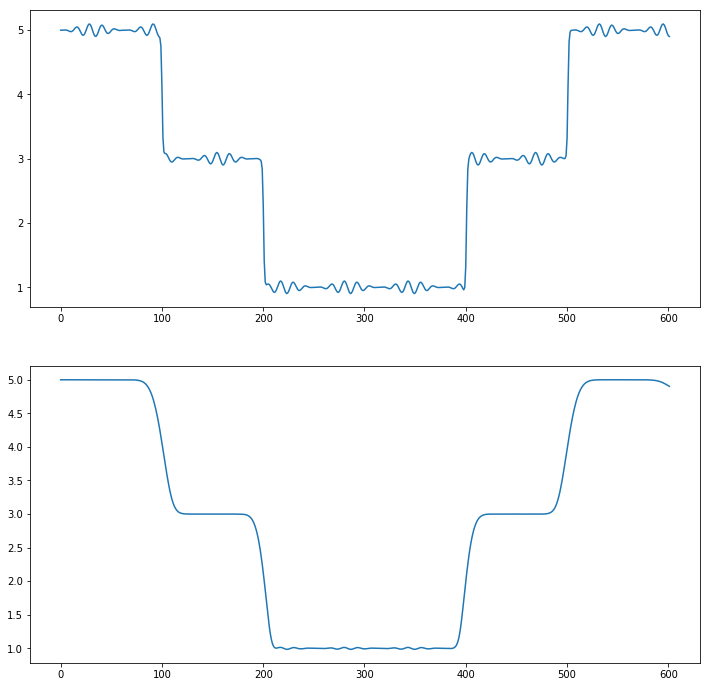

In [4]:
before_after_1D(U)

In 1D:

$$
    u_t = (g(|u_x|)u_x)_x = \Phi'(|u_x|))u_{xx}
$$

for $\Phi(s) = s\cdot g(s)$.

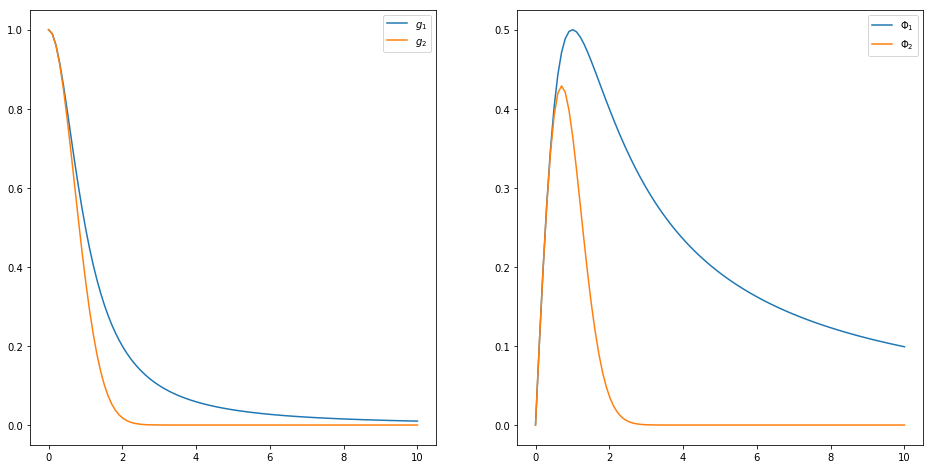

In [5]:
plt.figure(figsize = (16, 8))
plt.subplot(121)
plt.plot(s, g(s**2), label = "$g_1$")
plt.plot(s, g_exp(s**2), label = "$g_2$")
plt.legend()
plt.subplot(122)
plt.plot(s, ϕ(s**2), label = "$Φ_1$")
plt.plot(s, ϕ_exp(s**2), label = "$Φ_2$")
plt.legend()
plt.show()

## Discretization

First we semi-discretize the equation setting up a difference scheme for the spatial dimension, while keeping time continous:

$$
\begin{cases}
g_{i, j} = g\left(\left(\frac{u_{i+1, j} - u_{i-1, j}}{2h_x}\right)^2+\left(\frac{u_{i, j+1} - u_{i, j-1}}{2h_y}\right)^2\right) \\
g_{i+1/2,j} := \frac{g_{i+1,j} + g_{i,j}}{2} \\
\left[g \frac{\partial u}{\partial x}\right]_{i+1/2, j} \approx \phi_{i+1/2, j} := \left(\frac{u_{i+1, j} - u_{i, j}}{h_x}\right)\\
\left[\frac{\partial}{\partial x}\left(g\frac{\partial u}{\partial x}\right)\right]_{i,j} \approx \frac{\phi_{i+1/2,j} - \phi_{i-1/2,j}}{h_x} \\
\frac{\partial u_{i,j}}{\partial t} = \left[\frac{\partial}{\partial x}\left(g\frac{\partial u}{\partial x}\right)\right]_{i,j} + \left[\frac{\partial}{\partial y}\left(g\frac{\partial u}{\partial y}\right)\right]_{i,j} \approx  \frac{\phi_{i+1/2,j} - \phi_{i-1/2,j}}{h_y} + \frac{\phi_{i,j+1/2} - \phi_{i,j+1/2}}{h_y}\\
\frac{\partial u_{i,j}}{\partial t} = \frac{1}{h_x^2}\left[(g_{i,j} + g_{i−1,j})u_{i−1,j} + (-g_{i-1,j} - 2g_{i,j} - g_{i−1,j})u_{i, j} + (g_{i,j} + g_{i+1,j})u_{i+1,j}\right] + \frac{1}{h_y^2}\left[(g_{i,j} + g_{i,j-1})u_{i,j+1} + (-g_{i,j-1} - 2g_{i,j} - g_{i,j+1})u_{i, j} + (g_{i,j} + g_{i,j+1})u_{i,j+1}\right] \\
\end{cases}
$$

Reorder $u$ as an $(M+2)(N+2)$ vector, such that:

$$
\frac{d\mathbf{u}}{dt} = (A_x(\mathbf{u}) + A_y(\mathbf{u})) \mathbf{u} = A(\mathbf{u})\mathbf{u}
$$

In [6]:
def g(s):
    return 1/(1+s**2)

alpha = 30
x = np.linspace(0,6,1000)
M = 1000
N = 10000
h = 6/(M+1)
k = 0.01

y0 = [f(h*i, alpha) for i in range(M+2)]
x = [h*i for i in range(M+2)]
t0 = 0

def f(t, y, h):
    dydt = [0]
    for j in range(1, M+1):
        if j == 1:
            c0 = g(np.abs((y[j + 1] - y[j - 1]) / (2 * h)))
            cp = g(np.abs((y[j + 2] - y[j]) / (2 * h)))
            cm = g(np.abs((y[j+1] - y[j - 1]) / (2 * h)))
        elif j == M:
            c0 = g(np.abs((y[j + 1] - y[j - 1]) / (2 * h)))
            cp = g(np.abs((y[j + 1] - y[j-1]) / (2 * h)))
            cm = g(np.abs((y[j] - y[j - 2]) / (2 * h)))
        else:
            c0 = g(np.abs((y[j + 1] - y[j - 1]) / (2 * h)))
            cp = g(np.abs((y[j + 2] - y[j]) / (2 * h)))
            cm = g(np.abs((y[j] - y[j - 2]) / (2 * h)))

        betam = c0 + cm
        betap = c0 + cp
        alpha = -1*(cm + 2*c0 + cp)

        dydt.append(betam*y[j-1] + alpha*y[j] + betap*y[j+1])
    dydt.append(0)
    return dydt

r = ode(f).set_integrator('vode', method='bdf')
r.set_initial_value(y0, t0).set_f_params(h)
t1 = 100
dt = 0.02
while r.successful() and r.t < t1:
    y = r.integrate(r.t+dt)

In [7]:
Y = (y0, y)

Discretizing only in space, and then using a scipy ODE-solver:

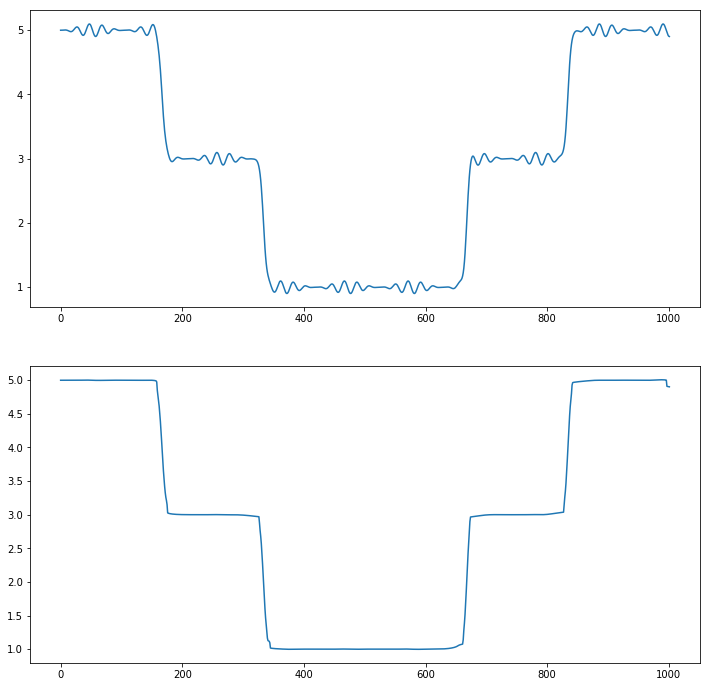

In [8]:
before_after_1D(Y)

Further discretising in time using forward differences we get the following explicit scheme:

$$
\mathbf{u}^{n+1} = \left[I - kA(\mathbf{u}^n)\right]\mathbf{u}^{n}
$$

We have also implemented a so-called semi-implicit scheme, in which we've used forward differences to approximate the diffusion function, while using backwards difference on the gradient-factor, and solve a linear system.

$$
 \left[I + kA(\mathbf{u}^n)\right]\mathbf{u}^{n+1} = \mathbf{u}^{n}
$$

In [25]:
M = 20
N = 20
K = (M+2)*(N+2)
g = lambda s: 1/(1+s)

T = 100
dt = 1

# I = load_image("lena-64x64.jpg", (M+2, N+2))
I = generate_random2D(N, M)
I = add_noise2D(I)

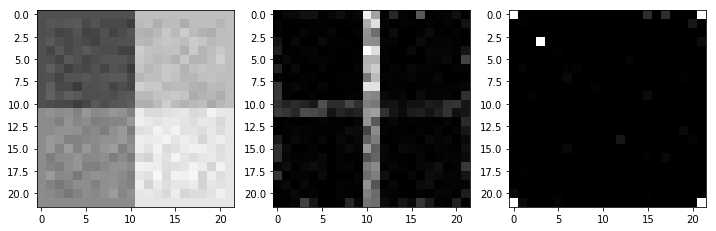

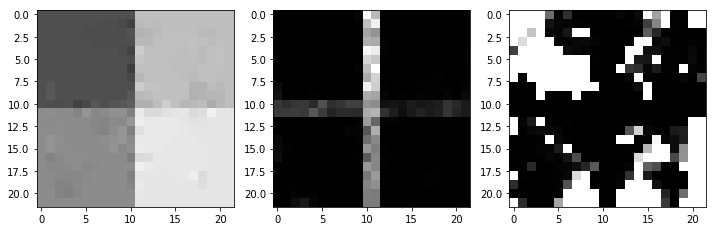

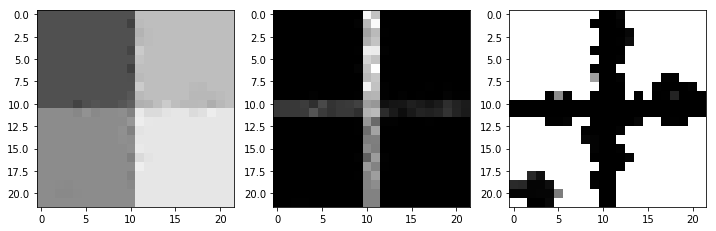

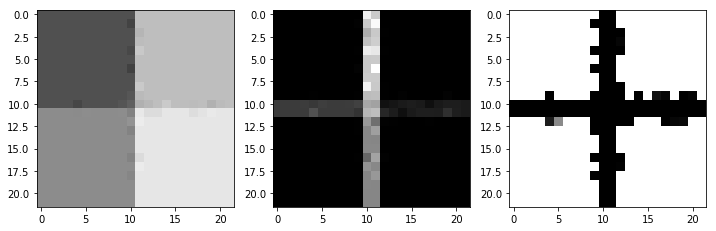

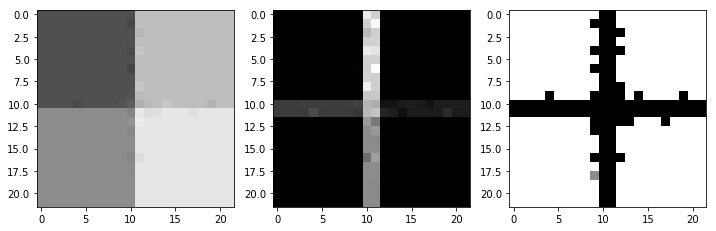

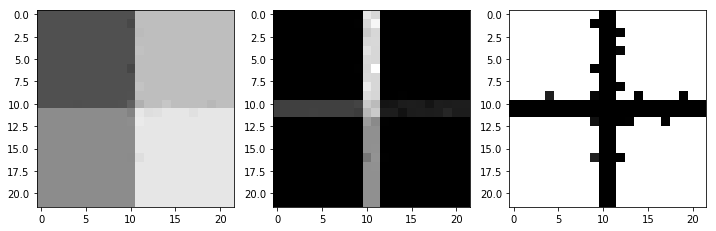

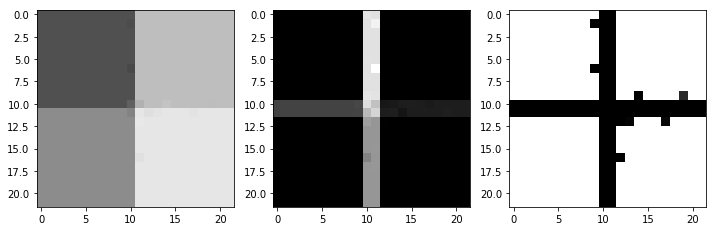

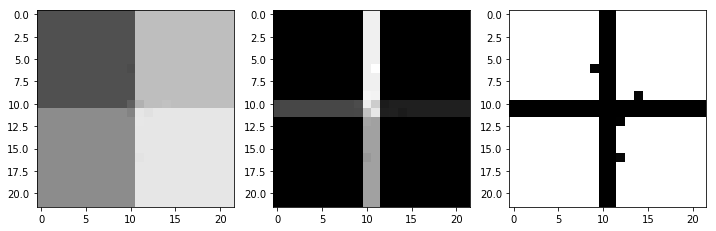

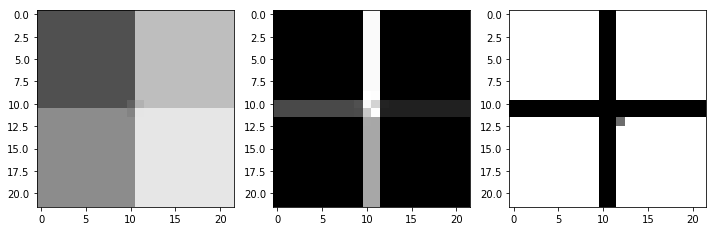

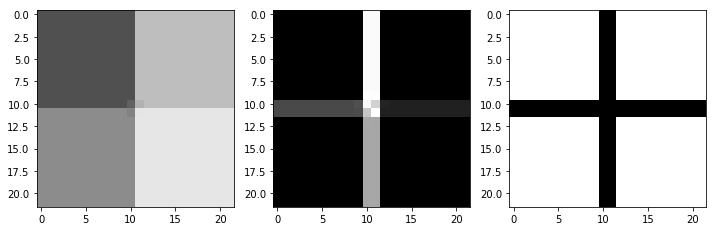

In [10]:
U = D2.solve_BE(I.reshape(K), g, M, N ,T, dt)

In [11]:
M = 62
N = 62
K = (M+2)*(N+2)
g = lambda s: 1/(1+s)

T = 1000
dt = 1

I = load_image("lena-64x64.jpg", (M+2, N+2))
I = add_noise2D(I)

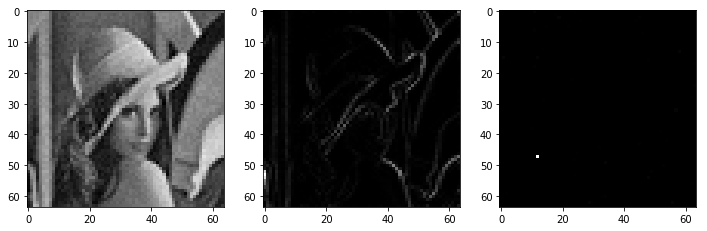

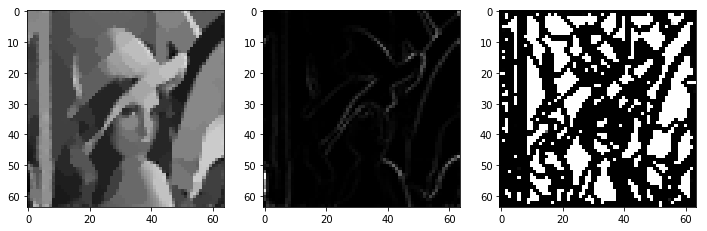

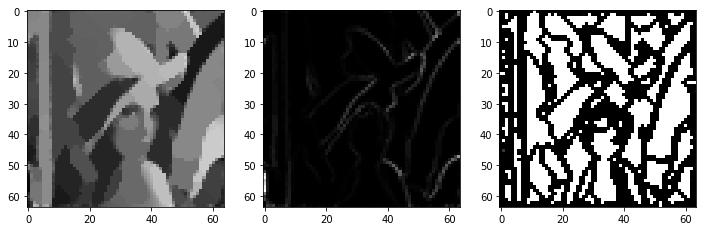

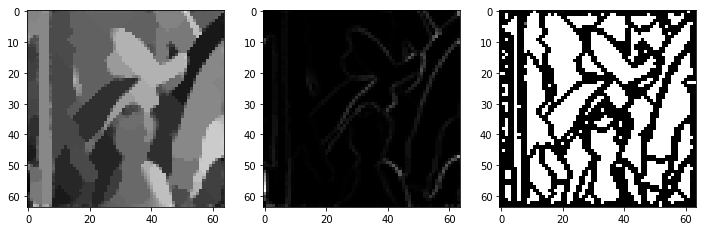

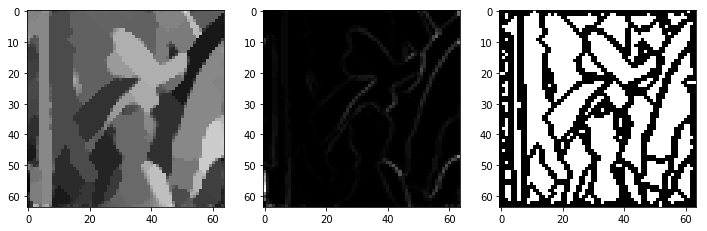

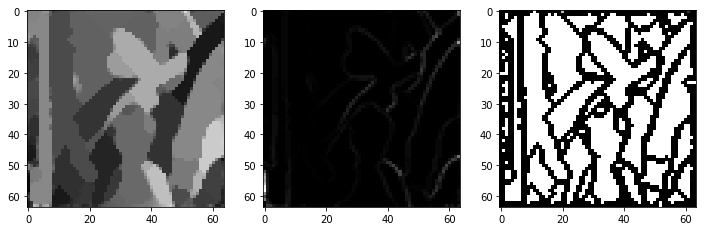

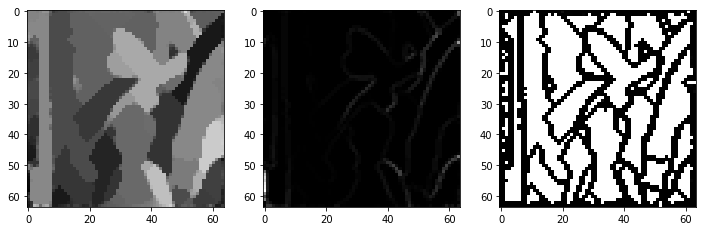

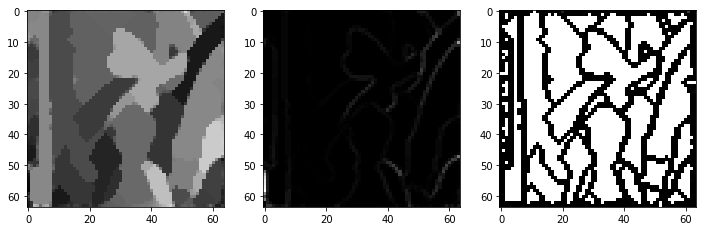

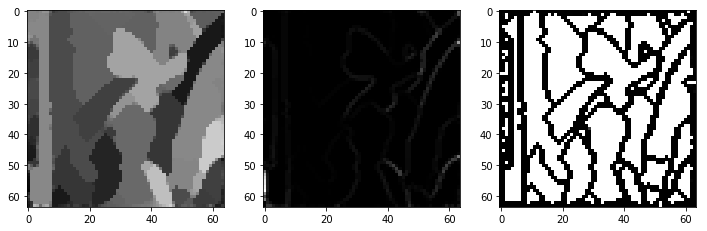

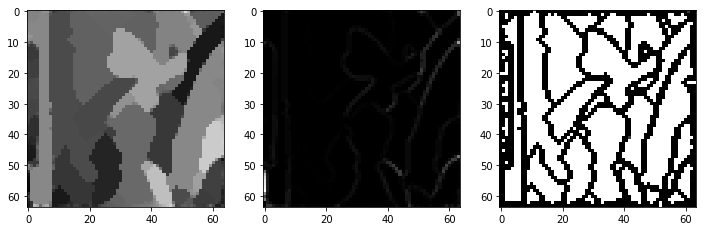

In [12]:
U = D2.solve_BE(I.reshape(K), g, M, N ,T, dt)

In [26]:
M = 62
N = 62
K = (M+2)*(N+2)
g = lambda s: 1/(1+s)

T = 1000
dt = 1e-1

I = load_image("lena-64x64.jpg", (M+2, N+2))
# I = generate_random2D(N, M)
I = add_noise2D(I)

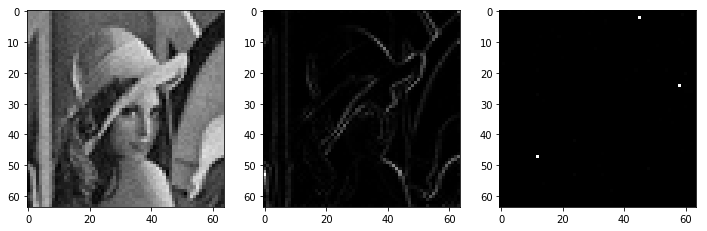

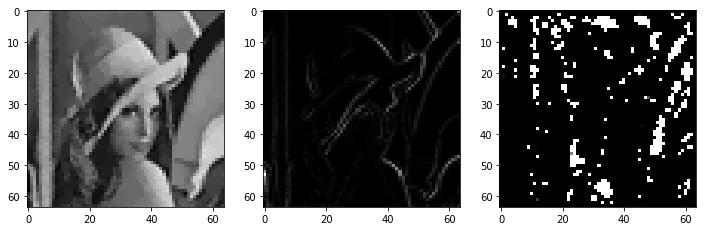

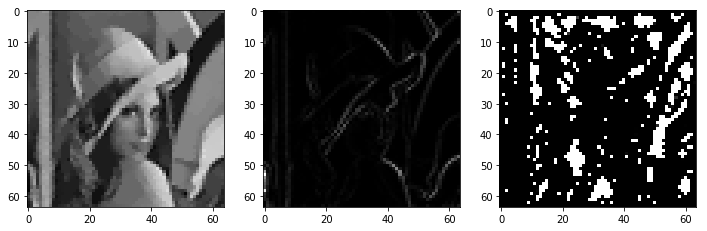

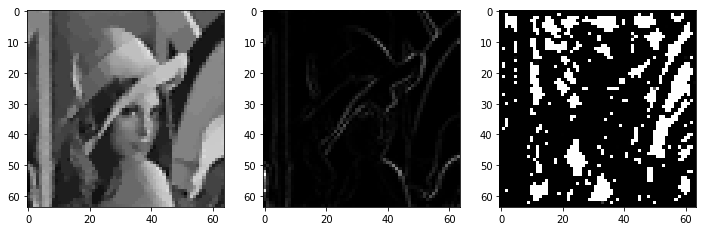

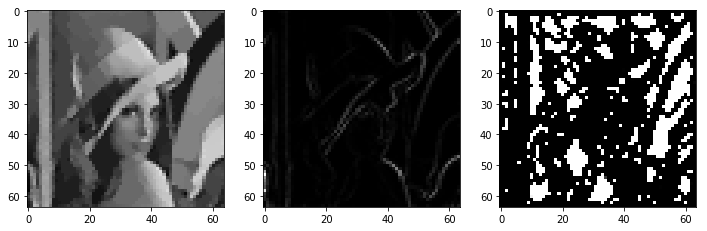

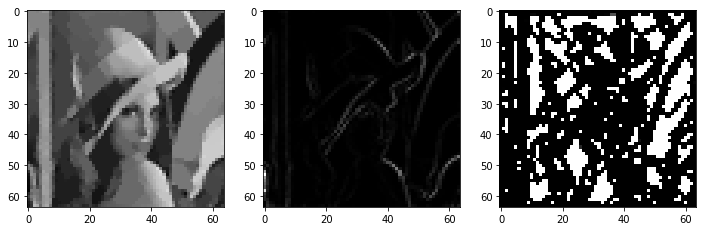

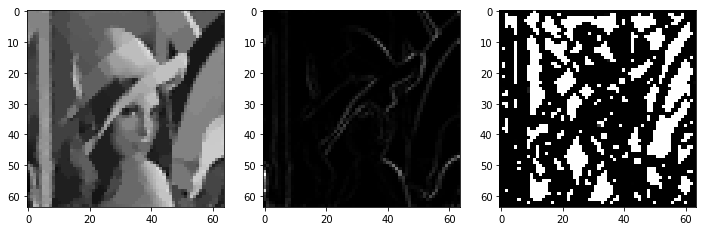

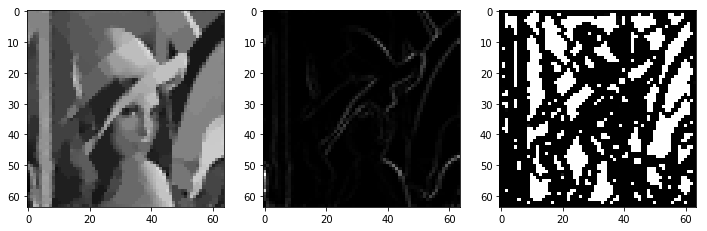

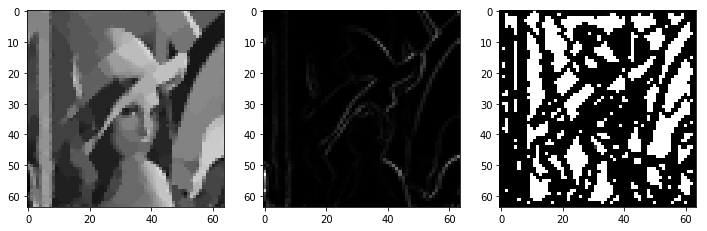

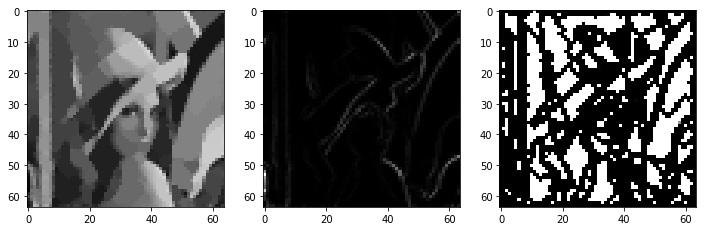

In [14]:
U = D2.solve_BE(I.reshape(K), g, M, N ,T, dt)

In [27]:
M = 98
N = 98
K = (M+2)*(N+2)
T = 100
dt = 1
I = load_image("dali.jpg", (M+2, N+2))
I = add_noise2D(I)

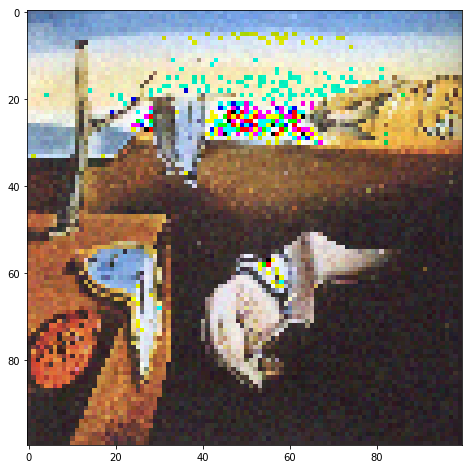

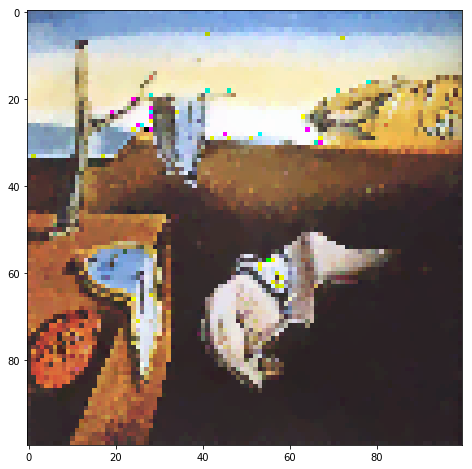

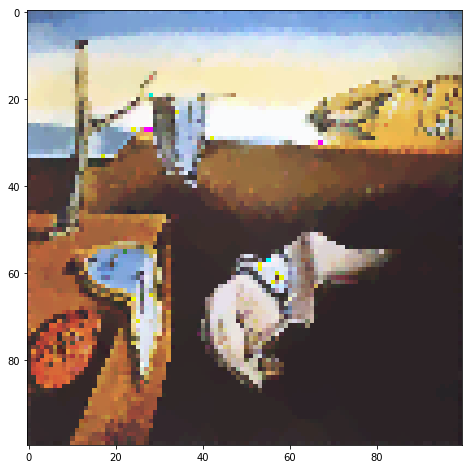

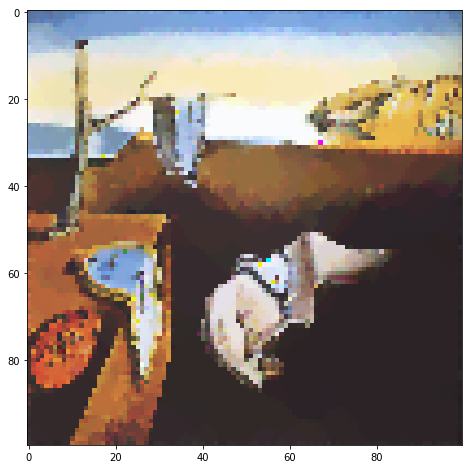

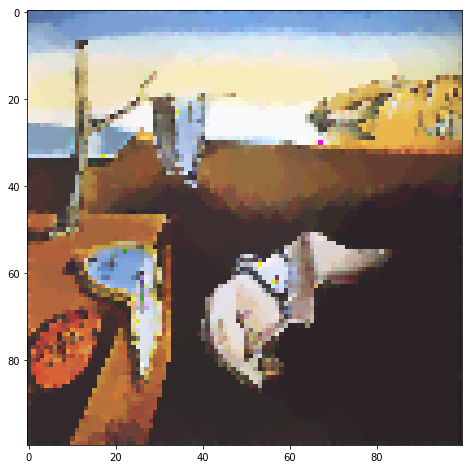

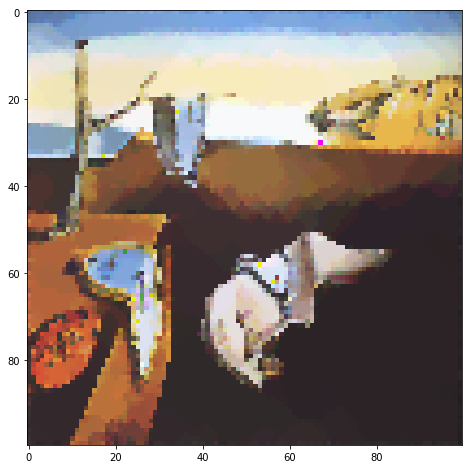

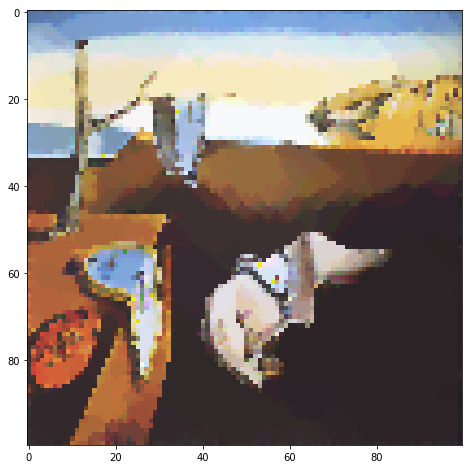

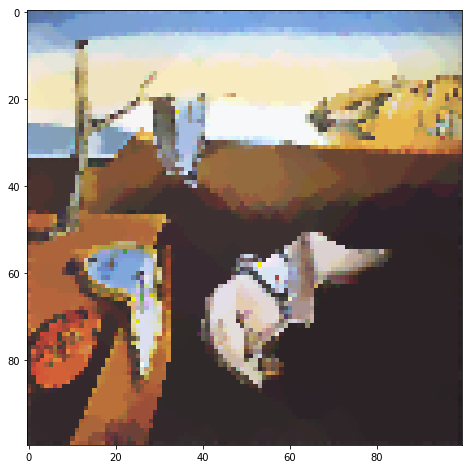

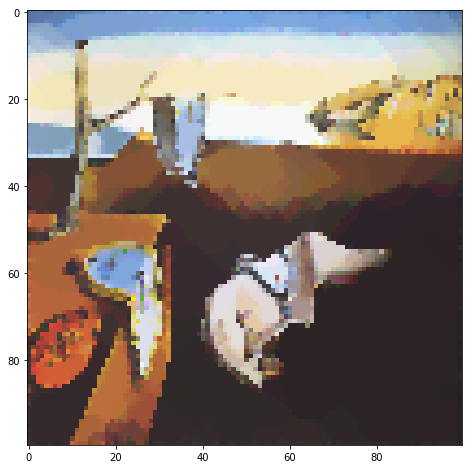

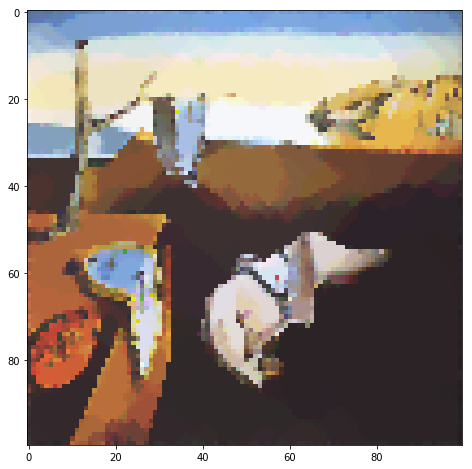

In [28]:
U = D2.solve_RGB_BE(I.reshape(K,3), g, M, N, T, dt)

### Consistency

\begin{align}
    u_m^{n+1} &= u_m^n + k \partial_t u_m^n + \frac{1}{2}k^2 \partial_t^2 u_m^n + ... \\
    &= u_m^n + k \partial_x g(|u_x|) u_x) + \frac{1}{2}k^2 \partial_t^2 u_m^n + ... \\
    &= u_m^n + k \partial_x (g(|\delta_x u_m^n + \frac{1}{3!}h^2 \partial_x^3 u_m^n + ...|) (\delta_x u_m^n + \frac{1}{2}h \partial_x^2 u_m^n + ...)) + \frac{1}{2}k^2 \partial_t^2 u_m^n + ... \\
    &\approx u_m^n + k \partial_x (g(|\delta_x u_m^n|) (\delta_x u_m^n + \frac{1}{2}h \partial_x^2 u_m^n)) + \frac{1}{2}k^2 \partial_t^2 u_m^n \\
    &= u_m^n + k \partial_x (g(|\delta_x u_m^n|) \delta_x u_m^n + g(|\delta_x u_m^n|) \frac{1}{2}h \partial_x^2 u_m^n) + \frac{1}{2}k^2 \partial_t^2 u_m^n \\
    &= u_m^n + k \partial_x g(|\delta_x u_m^n|) \delta_x u_m^n + k \partial_x g(|\delta_x u_m^n|) \frac{1}{2}h \partial_x^2 u_m^n + \frac{1}{2}k^2 \partial_t^2 u_m^n \\
    &= u_m^n + k \partial_x \left[g(|\delta_x u_m^n|) \delta_x u_m^n\right] + \mathcal{O}(hk) + \mathcal{O}(k^2) \\
    &= u_m^n + k \delta_x \left[g(|\delta_x u_m^n|) \delta_x u_m^n\right] + \mathcal{O}(h^2k) + \mathcal{O}(hk) + \mathcal{O}(k^2) \\
    \implies \tau_m^n &= \mathcal{O}(hk + k^2)
\end{align}

### Numerical verification

![alt text](conv_plot_2d.png "Title")